---
title: Gradient Considerations
date: 2023-04-01
authors:
  - name: J. Emmanuel Johnson
    affiliations:
      - MEOM Lab
    roles:
      - Primary Programmer
    email: jemanjohnson34@gmail.com
license: CC-BY-4.0
keywords: NerFs, Images
---

In [1]:
import autoroot
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax.random as jrandom
import numpy as np
import numba as nb
import equinox as eqx
import kernex as kex
import finitediffx as fdx
import diffrax as dfx
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm, trange
from jaxtyping import Float, Array, PyTree, ArrayLike
import wandb
from omegaconf import OmegaConf
import hydra
import metpy
from sklearn.pipeline import Pipeline
from jejeqx._src.transforms.dataframe.spatial import Spherical2Cartesian
from jejeqx._src.transforms.dataframe.temporal import TimeDelta
from jejeqx._src.transforms.dataframe.scaling import MinMaxDF


sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)
jax.config.update("jax_enable_x64", False)

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Recap Formulation

We are interested in learning non-linear functions $\boldsymbol{f}$.

$$
\begin{aligned}
\boldsymbol{f}(\mathbf{x}) &=
\mathbf{w}^\top\boldsymbol{\phi}(\mathbf{x})+\mathbf{b}
\end{aligned}
$$

where the $\boldsymbol{\phi}(\cdot)$ is a basis function. Neural Fields typically try to learn this basis funciton via a series of composite functions of the form

$$
\boldsymbol{\phi}(\mathbf{x}) =
\boldsymbol{\phi}_L\circ\boldsymbol{\phi}_{L-1}
\circ\cdots\circ
\boldsymbol{\phi}_2\circ\boldsymbol{\phi}_{1}(\mathbf{x})
$$

## Problems

Here, we will demonstrate a problem that a naive network has.

## Data

In [2]:
# !wget wget -nc https://s3.us-east-1.wasabisys.com/melody/osse_data/ref/NATL60-CJM165_GULFSTREAM_ssh_y2013.1y.nc

In [3]:
from pathlib import Path

In [4]:
Path("/gpfswork/rech/cli/uvo53rl/projects/jejeqx/data/natl60/NATL60-CJM165_GULFSTREAM_ssh_y2013.1y.nc").is_file()

True

In [5]:
from dataclasses import dataclass, field
from typing import List, Dict

@dataclass
class Subset:
    _target_: str = "builtins.slice"
    _args_: List = field(default_factory=lambda :["2013-01-01", "2013-01-01"])


@dataclass
class SSHDM:
    _target_: str = "jejeqx._src.datamodules.coords.AlongTrackDM"
    batch_size: int = 10_000
    shuffle: bool = False
    train_size: float = 0.80
    subset_size: float = 0.40
    spatial_coords: List = field(default_factory=lambda : ["lat", "lon"])
    temporal_coords: List = field(default_factory=lambda: ["time"])
    variables: List = field(default_factory=lambda : ["sossheig"])
    coarsen: Dict = field(default_factory=lambda : {"lon": 4, "lat": 4})
    resample: str = "1D"
    # paths: str = "/gpfswork/rech/cli/uvo53rl/projects/jejeqx/data/natl60/NATL60-CJM165_GULFSTREAM_ssh_y2013.1y.nc"
    paths: str = "/gpfswork/rech/yrf/commun/data_challenges/dc20a_osse/test/dc_ref/NATL60-CJM165_GULFSTREAM*"
    
    

# spatial transform
spatial_transforms = Pipeline([
    ("cartesian3d", Spherical2Cartesian(radius=1.0, units="degrees")),
    ("spatialminmax", MinMaxDF(["x", "y", "z"], -1, 1)),
])

temporal_transforms = Pipeline([
    ("timedelta", TimeDelta("2012-10-01", 1, "s")),
    ("timeminmax", MinMaxDF(["time"], -1, 1)),
])

In [6]:
select = {"time": slice("2013-01-01", "2013-01-01")}

config_dm = OmegaConf.structured(SSHDM())

dm = hydra.utils.instantiate(
    config_dm,
    select=select,
    spatial_transform=spatial_transforms,
    temporal_transform=temporal_transforms
)

dm.setup()



init = dm.ds_train[:32]
x_init, t_init, y_init = init["spatial"], init["temporal"], init["data"]
x_init.min(), x_init.max(), x_init.shape, t_init.min(), t_init.max(), t_init.shape

/gpfsdswork/projects/rech/cli/uvo53rl/projects/jejeqx/jejeqx/_src/transforms/dataframe/temporal.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["time"] = time
/gpfsdswork/projects/rech/cli/uvo53rl/projects/jejeqx/jejeqx/_src/transforms/dataframe/scaling.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[self.columns] = X_var


(-0.9857068930861228, 0.8492726832652533, (32, 3), -1.0, -1.0, (32, 1))

In [7]:
len(dm.ds_train)

7200

In [8]:
xrda = dm.load_xrds()

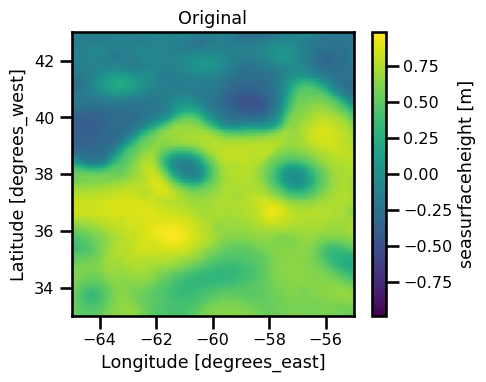

In [9]:
fig, ax = plt.subplots(ncols=1, figsize=(5,4))

xrda.sossheig.isel(time=0).plot.pcolormesh(ax=ax, cmap="viridis")
ax.set(title="Original")

plt.tight_layout()
plt.show()

In [10]:
# lr = 5e-3
# num_epochs = 5_000
# num_steps_per_epoch = len(dm.ds_train)

# @dataclass
# class FoxDataModule:
#     _target_: str = "jejeqx._src.datamodules.image.ImageFox"
#     batch_size: int = 10_000
#     train_size: float = 0.5
#     shuffle: bool = False
#     split_method: str = "even"
#     resize: int = 4
    
# @dataclass
# class Training:
#     num_epochs: int = 2_000

# @dataclass
# class Model:
#     _target_: str = "jejeqx._src.nets.nerfs.siren.SirenNet"
#     in_size: int = 2
#     out_size: int = 3
#     width_size: int = 128
#     depth: int = 5

# @dataclass
# class Optimizer:
#     _target_: str = "optax.adam"
#     learning_rate: float = lr
    
# @dataclass
# class Scheduler:
#     _target_: str = "optax.warmup_cosine_decay_schedule"
#     init_value: float = 0.0
#     peak_value: float = lr
#     warmup_steps: int = 100
#     decay_steps: int = int(num_epochs * num_steps_per_epoch)
#     end_value: float = 0.01 * lr
    
# @dataclass
# class Config:
#     datamodule: FoxDataModule = FoxDataModule()
#     model: Model = Model()
#     optimizer: Optimizer = Optimizer()
#     scheduler: Scheduler = Scheduler()
#     num_epochs: int = 2_000

In [11]:
# import optax

# config = Config()
# config = OmegaConf.structured(Config())

# # initialize datamodule
# dm = hydra.utils.instantiate(config.datamodule)

# dm.setup()


# # initialize optimizer
# optimizer = hydra.utils.instantiate(config.optimizer)

# # initialize scheduler
# num_steps_per_epoch = len(dm.ds_train)
# decay_steps = int(num_steps_per_epoch * config.num_epochs)
# schedule_fn = hydra.utils.instantiate(config.scheduler, decay_steps=decay_steps)

# # initialize optimizer + scheduler
# optimizer = optax.chain(optimizer, optax.scale_by_schedule(schedule_fn))



In [12]:
# ibatch = next(iter(dm.train_dataloader()))

# print(ibatch[0].shape, ibatch[1].shape, type(ibatch[0]))

## Model

The input data is a coordinate vector, $\mathbf{x}_\phi$, of the image coordinates.

$$
\mathbf{x}_\phi \in \mathbb{R}^{D_\phi}
$$

where $D_\phi = [\text{x}, \text{y}]$. So we are interested in learning a function, $\boldsymbol{f}$, such that we can input a coordinate vector and output a scaler/vector value of the pixel value.

$$
\mathbf{u} = \boldsymbol{f}(\mathbf{x}_\phi; \boldsymbol{\theta})
$$

### MLP Layer

$$
\mathbf{f}_\ell(\mathbf{x}) = \sigma\left(\mathbf{w}^{(\ell)}\mathbf{x} + \mathbf{b}^{(\ell)} \right)
$$

where $\sigma$ is the *swish* activation function.

$$
\sigma(\mathbf{x}) = \mathbf{x} \odot \text{Sigmoid}(\mathbf{x})
$$

In [13]:
from typing import Dict
from dataclasses import field


@dataclass
class Key:
    _target_: str = "jax.random.PRNGKey"
    seed: int = 123


@dataclass
class Activation:
    # _target_: str = "jejeqx._src.nets.activations.Tanh"
    _target_: str = "jejeqx._src.nets.activations.ReLU"
    # _target_: str = "jejeqx._src.nets.activations.Swish"

@dataclass
class Identity:
    _target_: str = "equinox.nn.Identity"
    
@dataclass
class MLPModel:
    _target_: str = "equinox.nn.MLP"
    in_size: int = 3
    out_size: int = 1
    width_size: int = 128
    depth: int = 5
    activation: Activation = Activation()
    final_activation: Identity = Identity()
    key: Key = Key()




In [14]:
# initialize model
model_config = OmegaConf.structured(MLPModel())

model = hydra.utils.instantiate(model_config)

# check output of models
out = jax.vmap(model)(x_init)

assert out.shape == y_init.shape
# eqx.tree_pprint(model)

## Optimizer (+ Learning Rate)

For this, we will use a simple adam optimizer with a `learning_rate` of 1e-4. From many studies, it appears that a lower learning rate works well with this methods because there is a lot of data. In addition, a bigger `batch_size` is also desireable. We will set the `num_epochs` to `1_000` which should be good enough for a single image. Obviously more epochs and a better learning rate scheduler would result in better results but this will be sufficient for this demo.

### Scheduler

<p align="center">
<img src="http://www.bdhammel.com/assets/learning-rate/resnet_loss.png" alt="drawing" width="300"/>
<figcaption align = "center">
  <b>Fig.1 - An example for learning rate reduction when the validation loss stagnates. Source: 
    <a href="http://www.bdhammel.com/assets/learning-rate/resnet_loss.png">Blog</a>
  </b>
  </figcaption>
</p>

We will use a simple learning rate scheduler - `reduce_lr_on_plateau`. This will automatically reduce the learning rate as the validation loss stagnates. It will ensure that we really squeeze out as much performance as possible from our models during the training procedure.We start with a (relatively) high `learning_rate` of `1e-4` so we will set the `patience` to 5 epochs. So if there is no change in with every epoch, we decrease the learning rate by a factor of `0.1`.

This is a rather crude (but effective) method but it tends to work well in some situations. A better method might be the `cosine_annealing` method or the `exponential_decay` method. See other [examples](https://www.kaggle.com/code/snnclsr/learning-rate-schedulers/).

In [15]:
@dataclass
class Optimizer:
    _target_: str = "optax.adam"
    learning_rate: float = 5e-6

In [16]:
import optax

num_epochs = 6_000
@dataclass
class Scheduler:
    _target_: str = "optax.warmup_cosine_decay_schedule"
    init_value: float = 0.0
    peak_value: float = 1e0
    warmup_steps: int = 500
    end_value: float = 1e-5

# num_epochs = 3_000
# @dataclass
# class Scheduler:
#     _target_: str = "optax.warmup_cosine_decay_schedule"
#     init_value: float = 0.0
#     peak_value: float = 1e-0
#     warmup_steps: int = 500
#     end_value: float = 1e-5
    
scheduler_config = OmegaConf.structured(Scheduler())

In [17]:
optim_config = OmegaConf.structured(Optimizer())

optimizer = hydra.utils.instantiate(optim_config)

# num_steps_per_epoch = len(dm.ds_train)

# scheduler = hydra.utils.instantiate(
#     scheduler_config, decay_steps=int(num_epochs * num_steps_per_epoch)
# )

# optimizer = optax.chain(optimizer, optax.scale_by_schedule(scheduler))

## Trainer Module

In [18]:
import glob
import os
from pathlib import Path

from jejeqx._src.trainers.base import TrainerModule
from jejeqx._src.trainers.callbacks import wandb_model_artifact
from jejeqx._src.losses import psnr


class RegressorTrainer(TrainerModule):
    def __init__(self,
                 model,
                 optimizer,
                 **kwargs):
        super().__init__(
            model=model, 
            optimizer=optimizer, 
            pl_logger=None,
            **kwargs
        )

    def create_functions(self):

        @eqx.filter_value_and_grad
        def mse_loss(model, batch):
            x, y = batch["spatial"], batch["data"]
            pred = jax.vmap(model)(x)
            loss = jnp.mean((y - pred)**2)
            return loss
        
        def train_step(state, batch):
            
            loss, grads = mse_loss(state.params, batch)
            state = state.update_state(state, grads)
            psnr_loss = psnr(loss) 
            metrics = {"loss": loss, "psnr": psnr_loss}
            return state, loss, metrics

        def eval_step(model, batch):
            loss, _ = mse_loss(model, batch)
            psnr_loss = psnr(loss) 
            return {"loss": loss, "psnr": psnr_loss}
        
        def test_step(model, batch):
            x, y = batch["spatial"], batch["data"]
            out = jax.vmap(model)(x)
            loss, _ = mse_loss(model, batch)
            psnr_loss = psnr(loss)
            return out, {"loss": loss, "psnr": psnr_loss}
        
        def predict_step(model, batch):
            x = batch["spatial"]
            out = jax.vmap(model)(x)
            return out

        return train_step, eval_step, test_step, predict_step
    
    
    def on_training_end(self,):
        
        if self.pl_logger:
            save_dir = Path(self.log_dir).joinpath(self.save_name)
            self.save_model(save_dir)
            wandb_model_artifact(self)
            self.pl_logger.finalize("success")
        
        


In [19]:
seed = 123
debug = False
enable_progress_bar = False
log_dir = "./"

trainer = RegressorTrainer(
    model, 
    optimizer, 
    seed=seed, 
    debug=debug, 
    enable_progress_bar=enable_progress_bar,
    log_dir=log_dir
)
train_more = False


In [20]:
%%time


out, metrics = trainer.test_model(dm.test_dataloader())
metrics

CPU times: user 1.37 s, sys: 68.2 ms, total: 1.43 s
Wall time: 1.07 s


{'loss': 0.3214516341686249, 'psnr': 7.565485000610352}

In [21]:
trainer.load_model("./checkpoints/checkpoint_model_mlp_ssh.ckpt")

In [22]:
%%time


out, metrics = trainer.test_model(dm.test_dataloader())
metrics

CPU times: user 86 ms, sys: 5.09 ms, total: 91.1 ms
Wall time: 87.8 ms


{'loss': 6.715777271892875e-05, 'psnr': 89.99620056152344}

In [23]:
%%time

if train_more:
    metrics = trainer.train_model(dm, num_epochs=num_epochs)

CPU times: user 19 µs, sys: 6 µs, total: 25 µs
Wall time: 46.7 µs


In [24]:
trainer.save_model("./checkpoints/checkpoint_model_mlp_ssh.ckpt")
# trainer.save_state("checkpoint_state.ckpt")

In [25]:
out, metrics = trainer.test_model(dm.test_dataloader())
metrics

{'loss': 6.715777271892875e-05, 'psnr': 89.99620056152344}

In [26]:
xrda["ssh_mlp"] = dm.data_to_df(out).to_xarray().sossheig

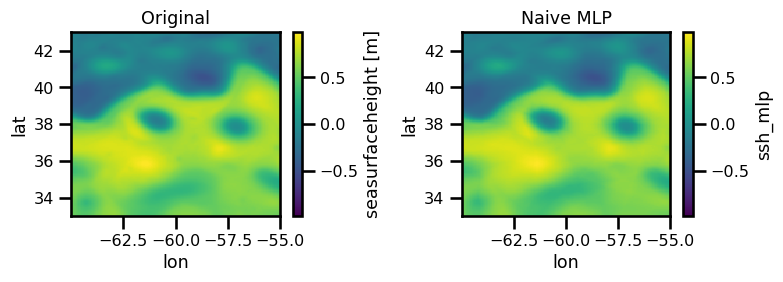

In [27]:
fig, ax = plt.subplots(ncols=2, figsize=(8,3))

xrda.sossheig.isel(time=0).plot.pcolormesh(ax=ax[0], cmap="viridis")
ax[0].set(title="Original")

xrda.ssh_mlp.isel(time=0).plot.pcolormesh(ax=ax[1], cmap="viridis")
ax[1].set(title="Naive MLP")

plt.tight_layout()
plt.show()

## Custom Activation Functions


**SIREN**

One of the most famous methods is the SIREN method. This replaces the standard activation function, $\sigma$, with a sinusoidal function.

$$
\phi(\mathbf{x})_\ell = \sin 
\left( \omega_\ell\left( 
\mathbf{w}_\ell\mathbf{x} + \mathbf{b}_\ell
\right)\right)
$$

In [28]:
from jejeqx._src.nets.nerfs.ffn import RFFLayer

model_name = "rff"


model = eqx.nn.Sequential(
    [RFFLayer(in_dim=3, num_features=256, out_dim=256, key=jrandom.PRNGKey(42)),
     RFFLayer(in_dim=256, num_features=256, out_dim=256, key=jrandom.PRNGKey(123)),
     RFFLayer(in_dim=256, num_features=256, out_dim=256, key=jrandom.PRNGKey(23)),
     RFFLayer(in_dim=256, num_features=256, out_dim=256, key=jrandom.PRNGKey(81)),
     RFFLayer(in_dim=256, num_features=256, out_dim=1, key=jrandom.PRNGKey(32)),
    ]
)
# network = equinox.nn.Linear()
# check output of models
out = jax.vmap(model)(x_init)

assert out.shape == y_init.shape

In [29]:
# @dataclass
# class Key:
#     _target_: str = "jax.random.PRNGKey"
#     seed: int = 123
    
    
# @dataclass
# class RFFBasis:
#     _target_: str = "jejeqx._src.nets.nerfs.encoders.GaussianFourierFeatureEncoding"
#     in_dim: int = 3
#     num_features: int = 256
#     key: Key = Key()
    

# # @dataclass
# # class SirenBasis:
# #     _target_: str = "jejeqx._src.nets.nerfs.siren.SirenNet"
# #     in_size: int = 3
# #     out_size: int = 128
# #     width_size: int = 128
# #     depth: int = 5
# #     key: Key = Key()
    
# @dataclass
# class LinearModel:
#     _target_: str = "equinox.nn.Linear"
#     in_features: int = 512
#     out_features: int = 1
#     use_bias: bool = True
#     key: Key = Key()
    
# @dataclass
# class NerFModel:
#     _target_: str = "jejeqx._src.nets.nerfs.base.NerF"
#     # basis_net: RFFBasis = RFFBasis()
#     basis_net: eqx.nn.Sequential = basis_net
    # network: LinearModel = LinearModel()

In [30]:
# # initialize model
# model_config = OmegaConf.structured(NerFModel())

# model = hydra.utils.instantiate(model_config)

# # check output of models
# out = jax.vmap(model)(x_init)

# assert out.shape == y_init.shape


In [31]:
# eqx.tree_pprint(model)

In [32]:
seed = 123
debug = False
enable_progress_bar = False
log_dir = "./"

trainer = RegressorTrainer(
    model, 
    optimizer, 
    seed=seed, 
    debug=debug, 
    enable_progress_bar=enable_progress_bar,
    log_dir=log_dir
)

train_more = True

In [33]:
%%time


out, metrics = trainer.test_model(dm.test_dataloader())
metrics

CPU times: user 2.49 s, sys: 51 ms, total: 2.54 s
Wall time: 2.16 s


{'loss': 0.261976957321167, 'psnr': 8.269335746765137}

In [34]:
trainer.load_model("./checkpoints/checkpoint_model_rff_ssh.ckpt")

In [35]:
%%time


out, metrics = trainer.test_model(dm.test_dataloader())
metrics

CPU times: user 2.31 s, sys: 21.7 ms, total: 2.33 s
Wall time: 1.53 s


{'loss': 6.510933872050373e-06, 'psnr': 113.08740234375}

In [36]:
# trainer.load_model("./checkpoints/checkpoint_model_siren_ssh.ckpt")

In [37]:
%%time

if train_more:

    metrics = trainer.train_model(dm, num_epochs=num_epochs)

Epochs: 6000 | Loss: 3.537e-06: 100%|██████████| 6000/6000 [04:29<00:00, 22.22it/s]

CPU times: user 4min 32s, sys: 7.88 s, total: 4min 40s
Wall time: 4min 29s


In [38]:
out, metrics = trainer.test_model(dm.test_dataloader())

metrics

{'loss': 5.135786068422021e-06, 'psnr': 115.5444564819336}

In [39]:
trainer.save_model("./checkpoints/checkpoint_model_rff_ssh.ckpt")

In [40]:
xrda["ssh_rfe"] = dm.data_to_df(out).to_xarray().sossheig

In [41]:
import common_utils as cutils

In [42]:
ds_rfe = cutils.calculate_physical_quantities(xrda.ssh_rfe)
ds_natl60 = cutils.calculate_physical_quantities(xrda.sossheig)
ds_mlp = cutils.calculate_physical_quantities(xrda.ssh_mlp)

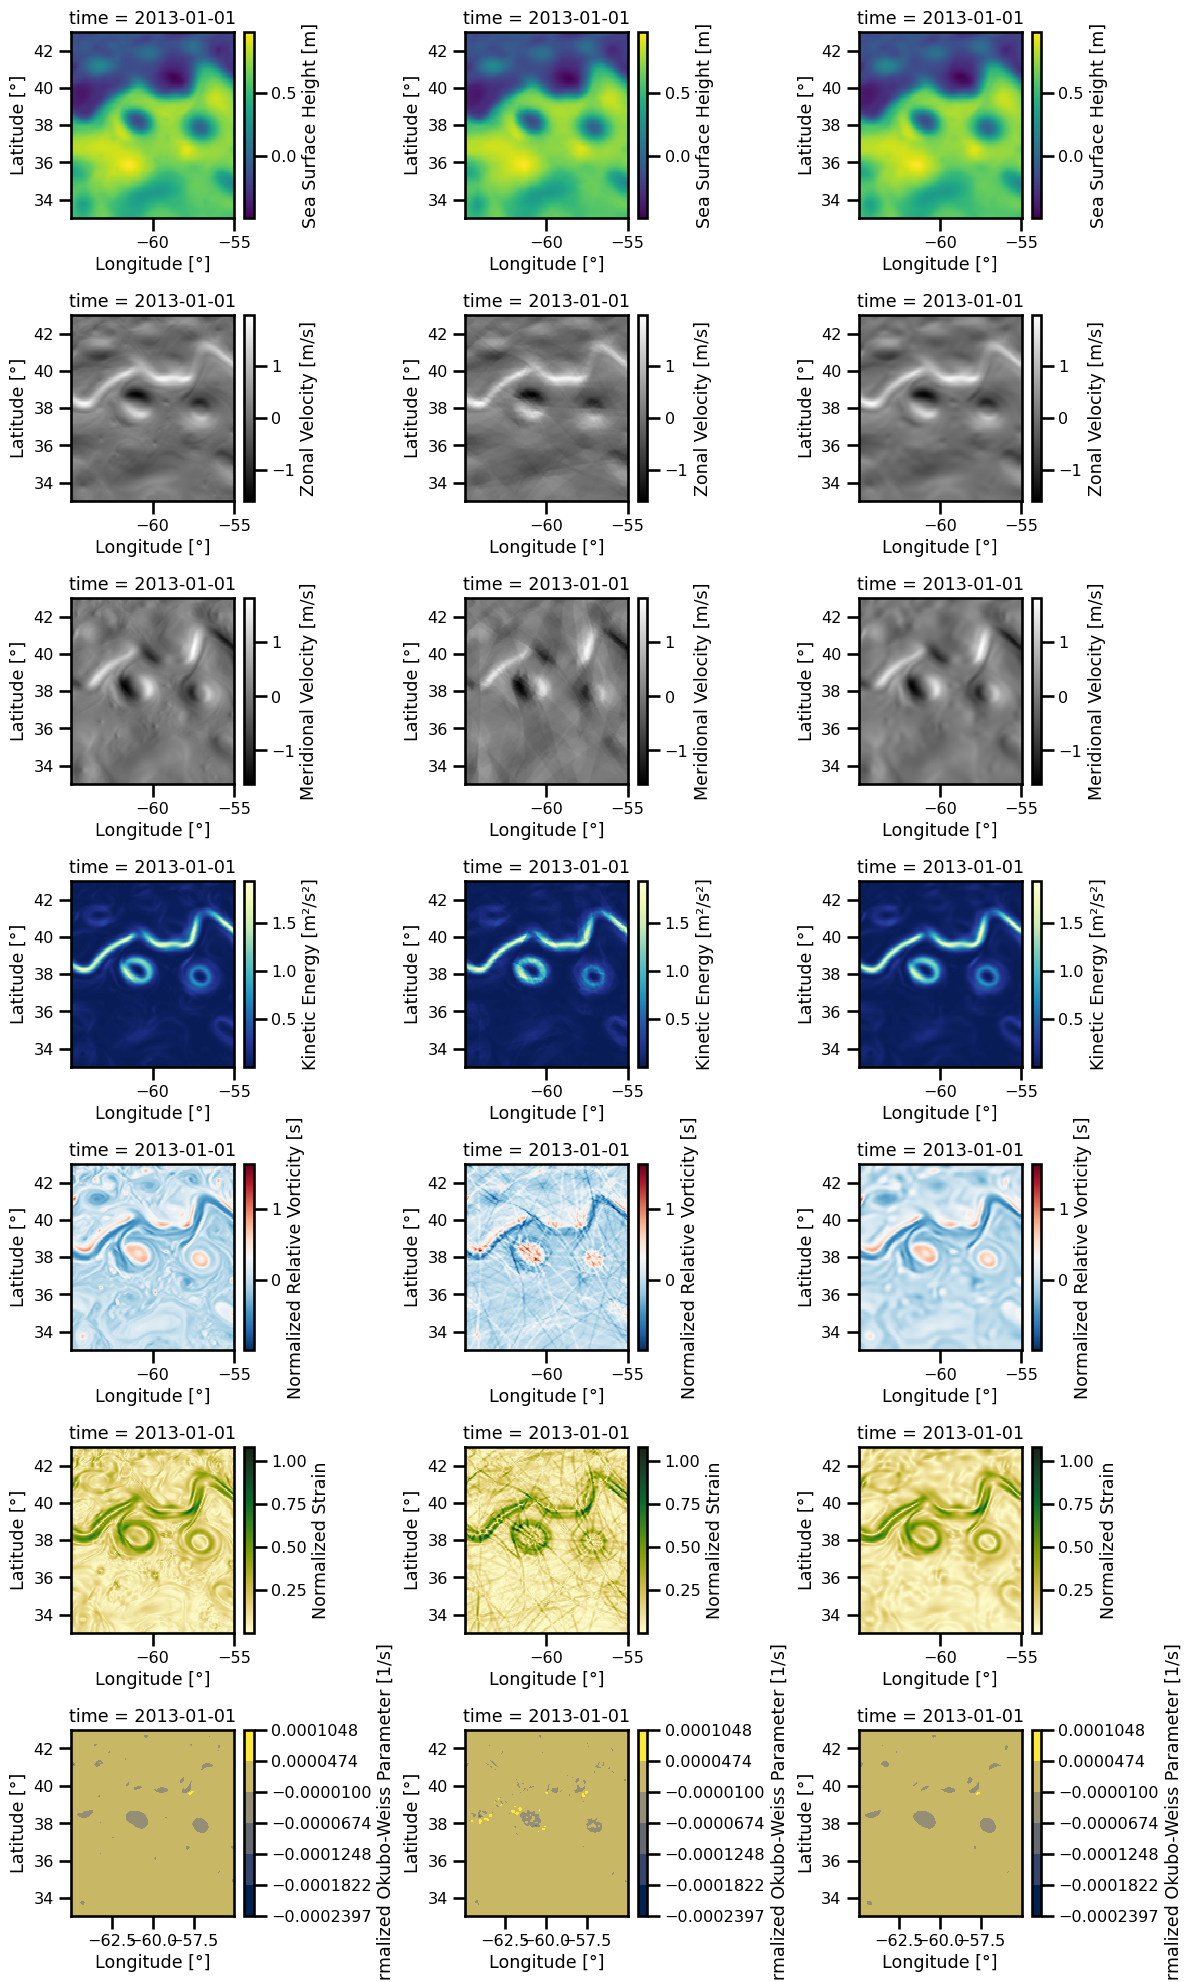

In [43]:
fig, ax = cutils.plot_analysis_vars([
    ds_natl60.isel(time=0),
    ds_mlp.isel(time=0),
    ds_rfe.isel(time=0),]
)
plt.show()

In [44]:
ds_psd_natl60 = cutils.calculate_isotropic_psd(ds_natl60)
ds_psd_rfe = cutils.calculate_isotropic_psd(ds_rfe)
ds_psd_mlp = cutils.calculate_isotropic_psd(ds_mlp)

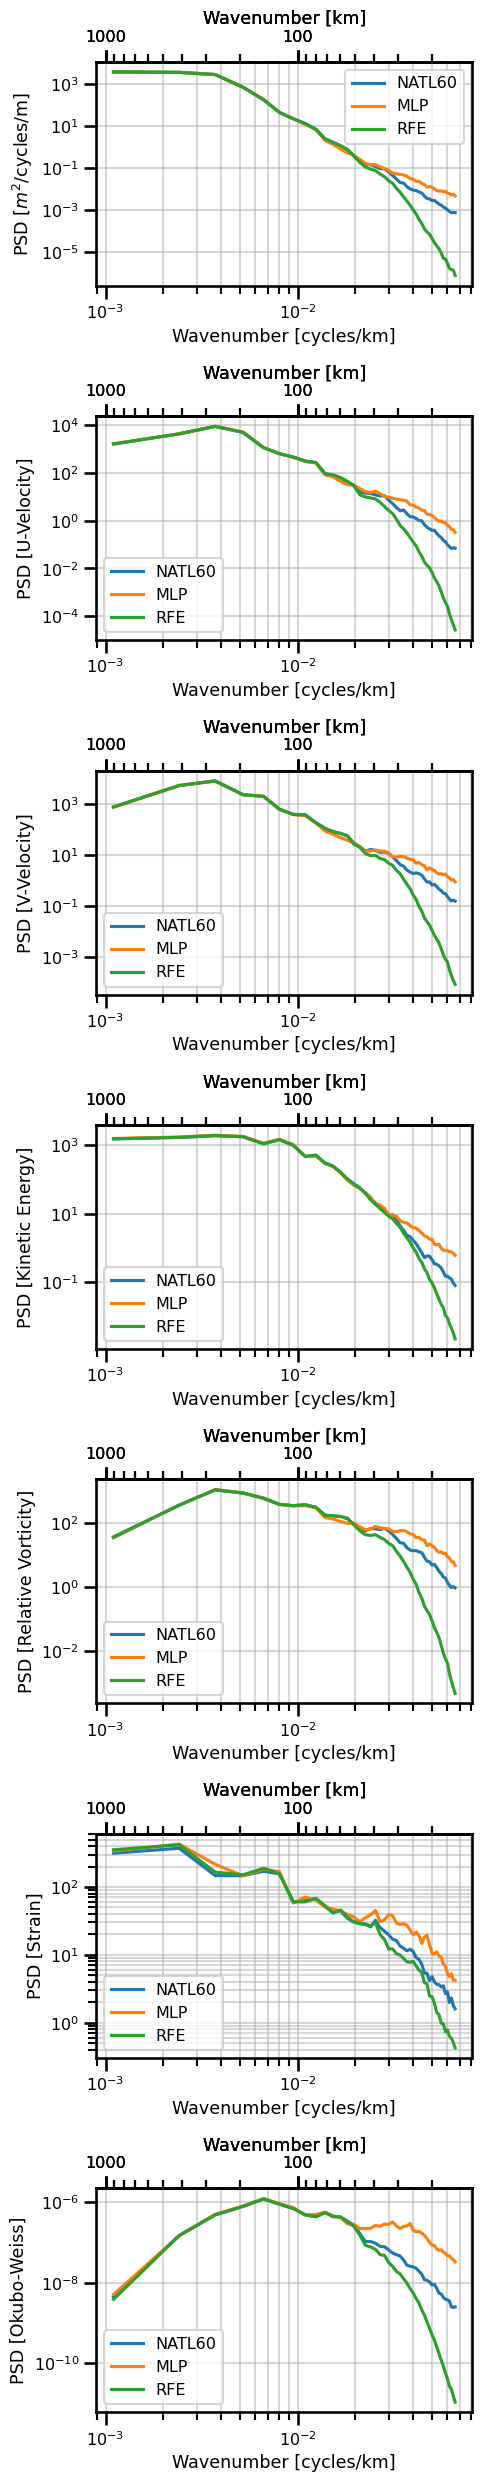

In [45]:
fig, ax = cutils.plot_analysis_psd_iso(
    [ds_psd_natl60, ds_psd_mlp, ds_psd_rfe,],
    ["NATL60", "MLP", "RFE", ]
)
plt.show()